Scikit-Learn The Random Team Lab 2

In [ ]:
#import statements
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import itertools
import random
import os

#processing imports
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

#model imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.cluster import KMeans
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

#deep learning
import tensorflow as tf


In [ ]:
#Display as much columns as possible
pd.set_option('display.max_columns', None)

# get current directory
current_dir = os.getcwd()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Extracting Data from KDD99 Dataset

In [ ]:
#fetch file
file_path = os.path.join(current_dir, 'dataset','kddcup99.csv')
 

#create dataframe
df = pd.read_csv(file_path)


In [ ]:
test_df = df.iloc[:112500]
df = df.iloc[112500:]

display(df.describe(include = [object]))
display(test_df.describe(include = [object]))

,protocol_type,service,flag,label
count,311848,311848,311848,311847
unique,3,64,10,16
top,icmp,ecr_i,SF,smurf
freq,247166,246569,262535,246281


,protocol_type,service,flag,label
count,112500,112500,112500,112500
unique,3,63,11,19
top,tcp,private,SF,neptune
freq,80689,39360,68576,41040


Formatting with Columns

In [ ]:
# add the column labels
columns = (['duration'
,'protocol_type'
,'service'
,'flag'
,'src_bytes'
,'dst_bytes'
,'land'
,'wrong_fragment'
,'urgent'
,'hot'
,'num_failed_logins'
,'logged_in'
,'num_compromised'
,'root_shell'
,'su_attempted'
,'num_root'
,'num_file_creations'
,'num_shells'
,'num_access_files'
,'num_outbound_cmds'
,'is_host_login'
,'is_guest_login'
,'count'
,'srv_count'
,'serror_rate'
,'srv_serror_rate'
,'rerror_rate'
,'srv_rerror_rate'
,'same_srv_rate'
,'diff_srv_rate'
,'srv_diff_host_rate'
,'dst_host_count'
,'dst_host_srv_count'
,'dst_host_same_srv_rate'
,'dst_host_diff_srv_rate'
,'dst_host_same_src_port_rate'
,'dst_host_srv_diff_host_rate'
,'dst_host_serror_rate'
,'dst_host_srv_serror_rate'
,'dst_host_rerror_rate'
,'dst_host_srv_rerror_rate'
,'label'])

df.columns = columns
test_df.columns = columns

# test dataframe's format and drop training and testing ratios to where 25% is 
df.head()


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
137500,0,tcp,http,SF,313,465,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,10,0.17,0.10,0.0,0.0,1.0,0.0,0.30,49,255,1.0,0.0,0.02,0.05,0.02,0.0,0.0,0.0,normal
137501,0,tcp,http,SF,315,603,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,16,23,0.06,0.04,0.0,0.0,1.0,0.0,0.13,59,255,1.0,0.0,0.02,0.05,0.02,0.0,0.0,0.0,normal
137502,0,tcp,http,SF,311,741,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0.00,0.00,0.0,0.0,1.0,0.0,0.00,69,255,1.0,0.0,0.01,0.04,0.01,0.0,0.0,0.0,normal
137503,0,tcp,http,SF,311,294,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,12,12,0.00,0.00,0.0,0.0,1.0,0.0,0.00,79,255,1.0,0.0,0.01,0.04,0.01,0.0,0.0,0.0,normal
137504,0,tcp,http,SF,196,3325,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0.00,0.00,0.0,0.0,1.0,0.0,0.00,2,255,1.0,0.0,0.50,0.04,0.00,0.0,0.0,0.0,normal


Creating Classifiers :column that encodes 'normal' values as 0 and any other value as 1. We will use this as our classifier for a simple binary model that idenfities any attack.

In [ ]:
# map normal to 0, all attacks to 1
is_attack = df.label.map(lambda a: 0 if a == 'normal' else 1)
test_attack = test_df.label.map(lambda a: 0 if a == 'normal' else 1)

#data_with_attack = df.join(is_attack, rsuffix='_flag')
df['attack_flag'] = is_attack
test_df['attack_flag'] = test_attack

# view the result
df.head()

<ipython-input-70-6ac69421019d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['attack_flag'] = is_attack
<ipython-input-70-6ac69421019d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['attack_flag'] = test_attack


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,attack_flag
137500,0,tcp,http,SF,313,465,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,10,0.17,0.10,0.0,0.0,1.0,0.0,0.30,49,255,1.0,0.0,0.02,0.05,0.02,0.0,0.0,0.0,normal,0
137501,0,tcp,http,SF,315,603,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,16,23,0.06,0.04,0.0,0.0,1.0,0.0,0.13,59,255,1.0,0.0,0.02,0.05,0.02,0.0,0.0,0.0,normal,0
137502,0,tcp,http,SF,311,741,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0.00,0.00,0.0,0.0,1.0,0.0,0.00,69,255,1.0,0.0,0.01,0.04,0.01,0.0,0.0,0.0,normal,0
137503,0,tcp,http,SF,311,294,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,12,12,0.00,0.00,0.0,0.0,1.0,0.0,0.00,79,255,1.0,0.0,0.01,0.04,0.01,0.0,0.0,0.0,normal,0
137504,0,tcp,http,SF,196,3325,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0.00,0.00,0.0,0.0,1.0,0.0,0.00,2,255,1.0,0.0,0.50,0.04,0.00,0.0,0.0,0.0,normal,0


Transforming our Data for Classification

Classify each of the attacks according to attack type for a prediction model.

Denial of Service attacks:
apache2
back
land
neptune
mailbomb
pod
processtable
smurf
teardrop
udpstorm
worm

Probe attacks:
ipsweep
mscan
nmap
portsweep
saint
satan

Privilege escalation attacks:
buffer_overflow
loadmdoule
perl
ps
rootkit
sqlattack
xterm

Remote access attacks:
ftp_write
guess_passwd
http_tunnel
imap
multihop
named
phf
sendmail
snmpgetattack
snmpguess
spy
warezclient
warezmaster
xclock
xsnoop

In [ ]:
#Place attack classifications into lists
dos_attacks = ['apache2','back','land','neptune','mailbomb','pod','processtable','smurf','teardrop','udpstorm','worm']
probe_attacks = ['ipsweep','mscan','nmap','portsweep','saint','satan']
privilege_attacks = ['buffer_overflow','loadmdoule','perl','ps','rootkit','sqlattack','xterm']
access_attacks = ['ftp_write','guess_passwd','http_tunnel','imap','multihop','named','phf','sendmail','snmpgetattack','snmpguess','spy','warezclient','warezmaster','xclock','xsnoop']

#Create attack labels
attack_labels = ['Normal', 'DOS', 'Probe', 'Privilege', 'Access']


#Function for mapping our class labels to attack types
def map_attack(label):
    if label in dos_attacks:
        # dos_attacks map to 1
        attack_type = 1
    elif label in probe_attacks:
        # probe_attacks map to 2
        attack_type = 2
    elif label in privilege_attacks:
        # privilege escalation attacks map to 3
        attack_type = 3
    elif label in access_attacks:
        # remote access attacks map to 4
        attack_type = 4
    
    else:
        # normal maps to 0
        attack_type = 0
        
    return attack_type

# map the data and join to the data set
train_attack_map = df.label.apply(map_attack)
df['attack_map'] = train_attack_map


# view the result
df.head(100)

<ipython-input-71-b2fc61ae2c65>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['attack_map'] = train_attack_map


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,attack_flag,attack_map
137500,0,tcp,http,SF,313,465,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,10,0.17,0.10,0.0,0.0,1.0,0.0,0.30,49,255,1.0,0.0,0.02,0.05,0.02,0.0,0.0,0.0,normal,0,0
137501,0,tcp,http,SF,315,603,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,16,23,0.06,0.04,0.0,0.0,1.0,0.0,0.13,59,255,1.0,0.0,0.02,0.05,0.02,0.0,0.0,0.0,normal,0,0
137502,0,tcp,http,SF,311,741,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0.00,0.00,0.0,0.0,1.0,0.0,0.00,69,255,1.0,0.0,0.01,0.04,0.01,0.0,0.0,0.0,normal,0,0
137503,0,tcp,http,SF,311,294,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,12,12,0.00,0.00,0.0,0.0,1.0,0.0,0.00,79,255,1.0,0.0,0.01,0.04,0.01,0.0,0.0,0.0,normal,0,0
137504,0,tcp,http,SF,196,3325,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0.00,0.00,0.0,0.0,1.0,0.0,0.00,2,255,1.0,0.0,0.50,0.04,0.00,0.0,0.0,0.0,normal,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137595,0,tcp,http,SF,221,3621,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,18,19,0.00,0.00,0.0,0.0,1.0,0.0,0.11,34,255,1.0,0.0,0.03,0.03,0.00,0.0,0.0,0.0,normal,0,0
137596,0,tcp,http,SF,212,6345,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.00,0.00,0.0,0.0,1.0,0.0,0.00,44,255,1.0,0.0,0.02,0.03,0.00,0.0,0.0,0.0,normal,0,0
137597,0,tcp,http,SF,200,7384,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,16,17,0.00,0.00,0.0,0.0,1.0,0.0,0.12,54,255,1.0,0.0,0.02,0.03,0.00,0.0,0.0,0.0,normal,0,0
137598,0,tcp,http,SF,198,812,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,4,13,0.00,0.00,0.0,0.0,1.0,0.0,0.15,64,255,1.0,0.0,0.02,0.03,0.00,0.0,0.0,0.0,normal,0,0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['attack_map'], df['attack_flag'], test_size=0.25, random_state=42)

X_train = X_train.to_frame()
y_train = y_train.to_frame()
X_test = X_test.to_frame()
y_test = y_test.to_frame()

print(X_train.columns)
print(y_train.columns)
print(X_test.columns)
print(X_test.columns)



Index(['attack_map'], dtype='object')
Index(['attack_flag'], dtype='object')
Index(['attack_map'], dtype='object')
Index(['attack_map'], dtype='object')


Data Distribution

In [ ]:

#Count the frequency of different types of attack (class labels)
train_attack_counts = X_train.value_counts()
test_attack_counts = X_test.value_counts()


#Calculate training percentages with overall count of the dataframe
train_attack_percentages = 100 * train_attack_counts / len(df)

train_attack_percentages = round(train_attack_percentages, 2)

train_attack_percentages = train_attack_percentages.round(2).astype(str) + "%"

test_attack_percentages = 100 * test_attack_counts / len(df)

test_attack_percentages = round(test_attack_percentages, 2)

test_attack_percentages = test_attack_percentages.round(2).astype(str) + "%"


distribution_columns = {"Class": attack_labels, "Training Set": train_attack_counts, "Train-SET Percentage": train_attack_percentages, "Testing Set": test_attack_counts, "Test-SET Percentage": test_attack_percentages} 

distribution_df = pd.DataFrame(distribution_columns)

distribution_df.head()




,Class,Training Set,Train-SET Percentage,Testing Set,Test-SET Percentage
attack_map,,,,,
1,Normal,274318,87.97%,91654,29.39%
0,DOS,58953,18.9%,19473,6.24%
2,Probe,2863,0.92%,934,0.3%
4,Privilege,854,0.27%,271,0.09%
3,Access,23,0.01%,5,0.0%


Classification Process

In [ ]:
def compute_metrics(predictions, true_labels):
    labels = true_labels
    preds = predictions
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds,
                                                               average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

Feature Engineering

Discrete Features: **protocol_type** (tcp, udp, etc mapped to numbers: 0,1,2) 

**service** (service running on the destination (telnet, http, etc mapped to numbers: 0,1, 2)

**flag** (normal or error status of the connection, 0 or 1)
                  

Continious features 

**Duration** (length (number of seconds) of the connection)

**srv_diff_host_rate** (% of connections to different hosts)

**dst_bytes** (number of data bytes flowing from destination to source) 	






In [ ]:
# get the intial set of encoded features and encode them
features_to_encode = ['protocol_type', 'service', 'flag']
encoded = pd.get_dummies(df[features_to_encode])
test_encoded_base = pd.get_dummies(test_df[features_to_encode])

# not all of the features are in the test set, so we need to account for diffs
test_index = np.arange(len(test_df.index))
column_diffs = list(set(encoded.columns.values)-set(test_encoded_base.columns.values))

diff_df = pd.DataFrame(0, index=test_index, columns=column_diffs)

# we'll also need to reorder the columns to match, so let's get those
column_order = encoded.columns.to_list()

# append the new columns
test_encoded_temp = test_encoded_base.join(diff_df)

# reorder the columns
test_final = test_encoded_temp[column_order].fillna(0)

# get numeric features, we won't worry about encoding these at this point
numeric_features = ['duration', 'srv_diff_host_rate', 'dst_bytes']

# model to fit/test
to_fit = encoded.join(df[numeric_features])
test_set = test_final.join(test_df[numeric_features])

Decision Tree Model

In [ ]:
binary_model = DecisionTreeClassifier()
binary_model.fit(binary_train_X, binary_train_y)
y_pred = binary_model.predict(binary_val_X)

metrics_list = compute_metrics(y_pred, binary_val_y)
    #---------------------------------------------------------------#
results = pd.DataFrame(metrics_list, columns = ['accuracy', 'precision', 'recall', 'f1'], index=[0])
results['Type'] = 'Classical Machine Learning'
results['Model'] = 'Decision Tree C4.5'
results = results[['Type', 'Model', 'accuracy', 'precision', 'recall', 'f1']]
display(results)

,Type,Model,accuracy,precision,recall,f1
0,Classical Machine Learning,Decision Tree C4.5,0.980644,0.980417,0.980704,0.980556


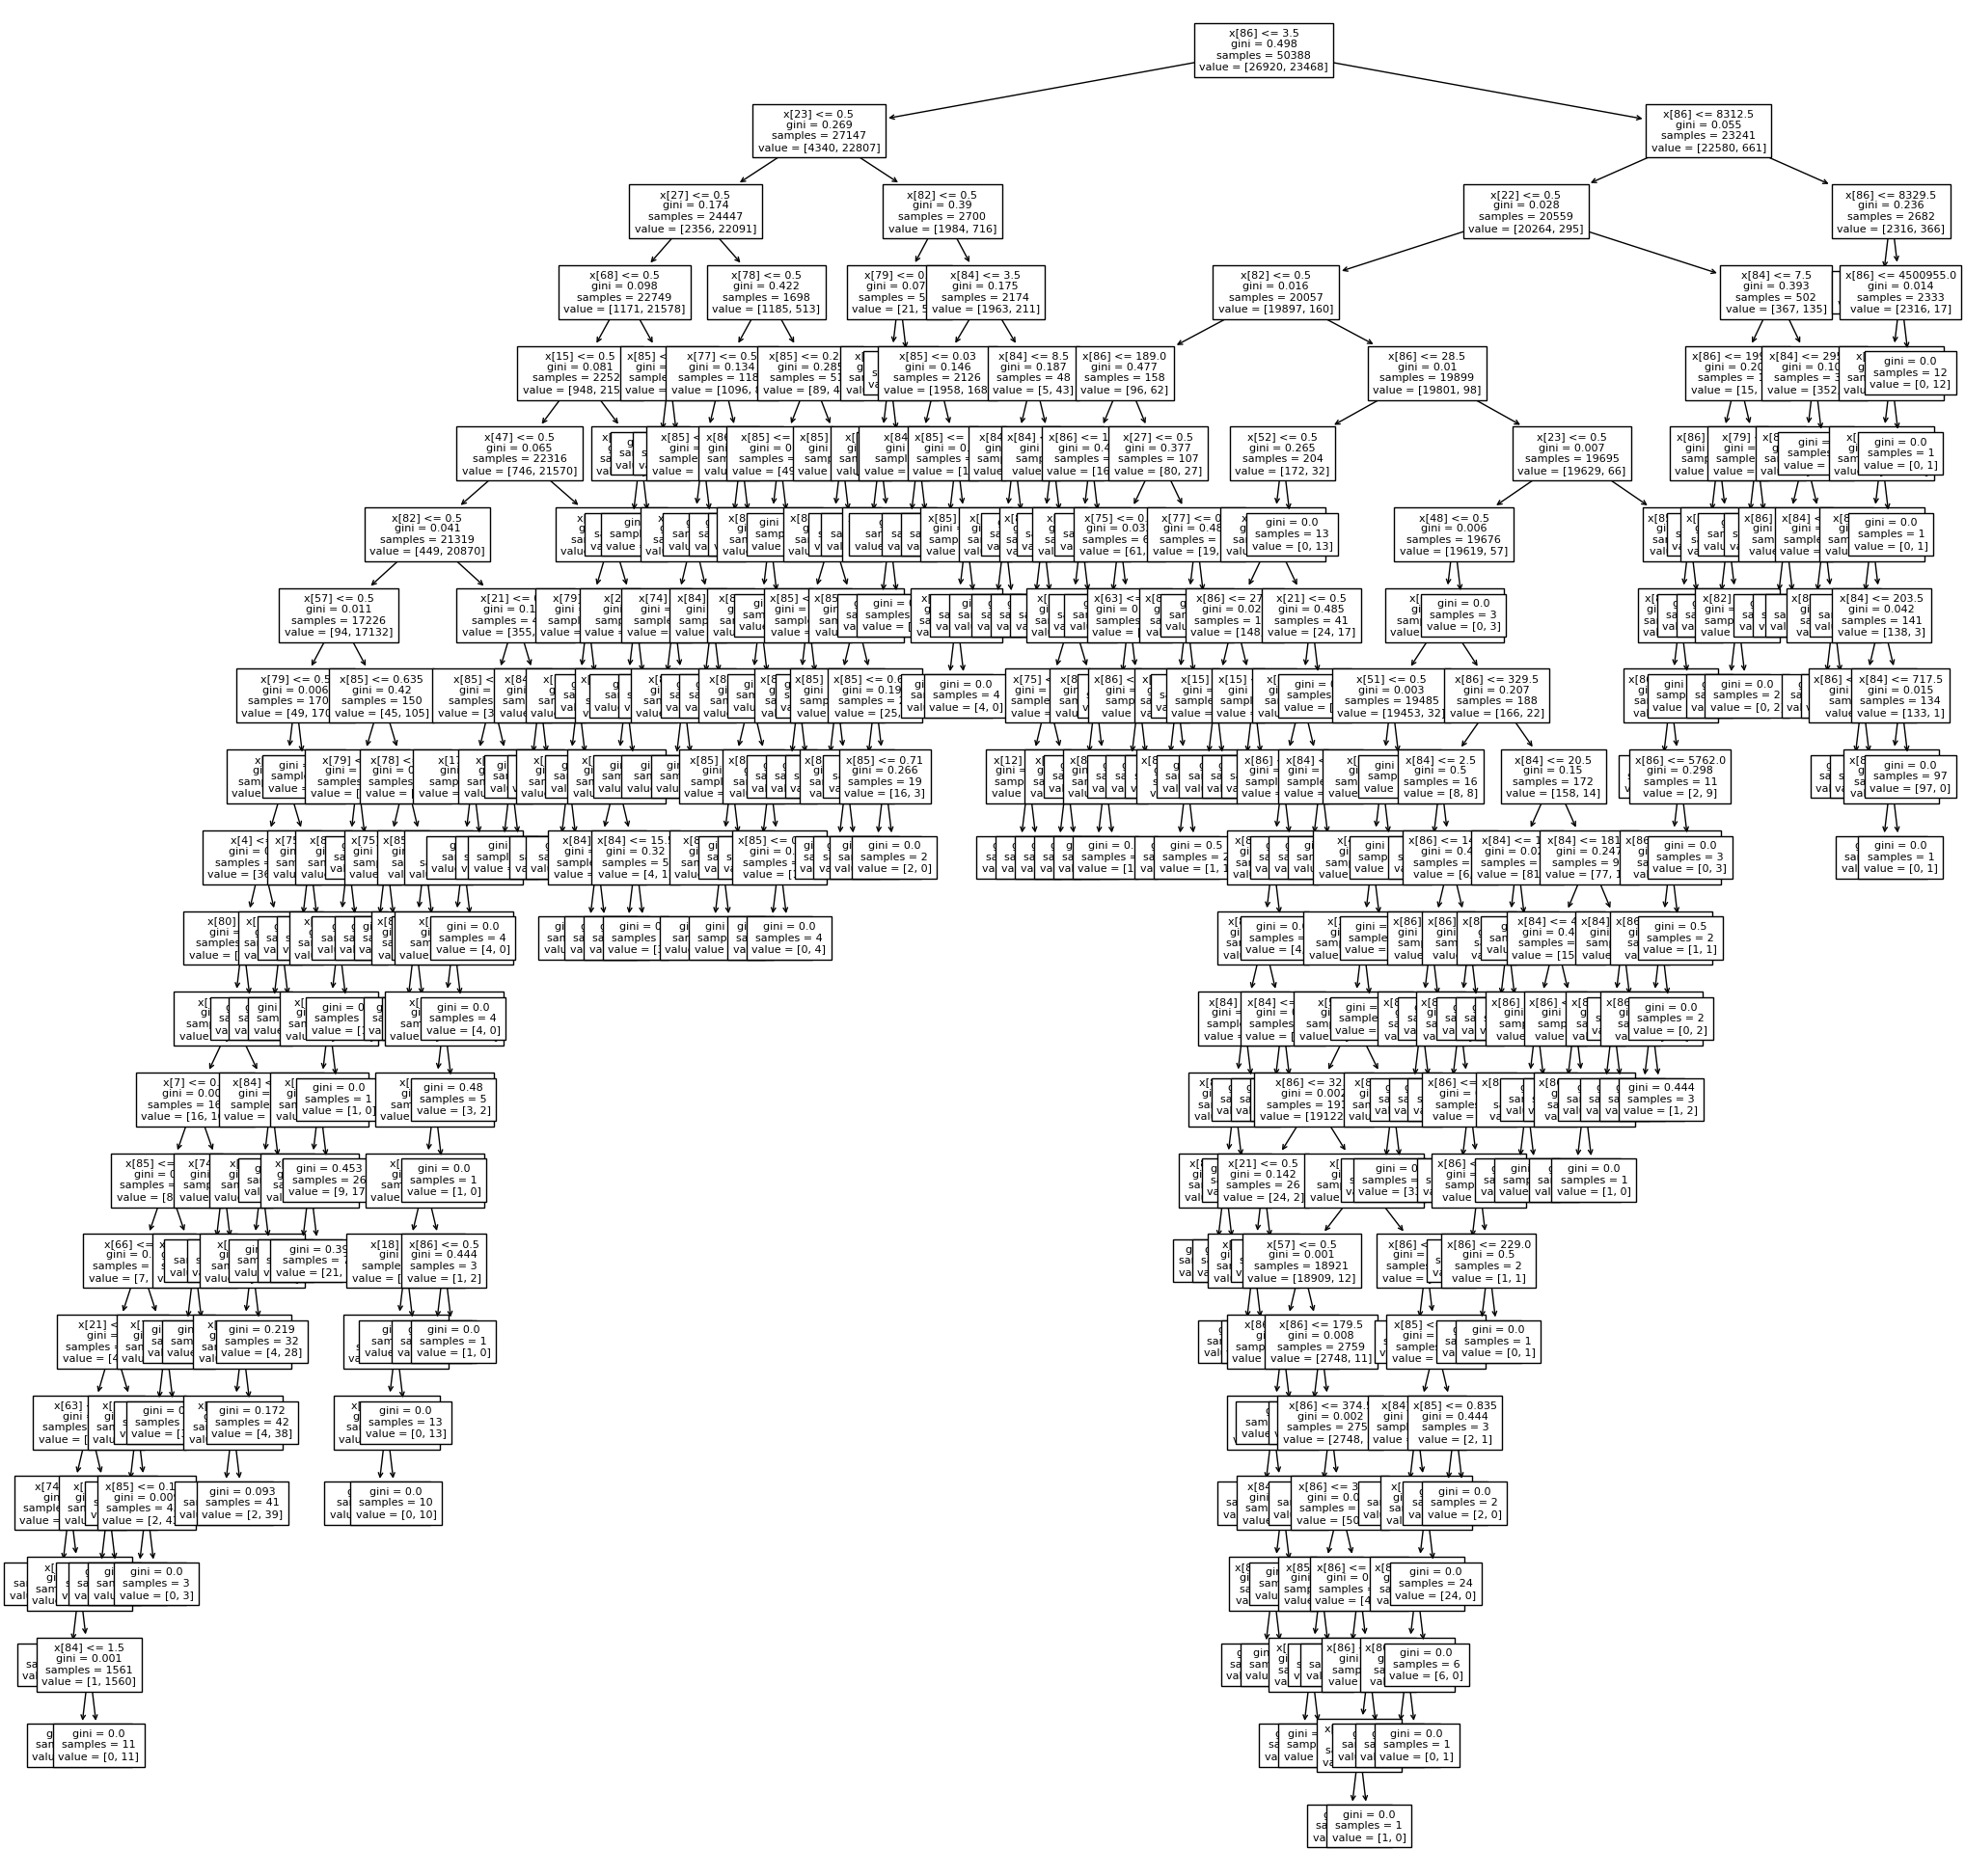

In [ ]:
plt.figure(figsize=(25, 25))  # set plot size
plot_tree(binary_model, fontsize=8)
plt.show()

Loop through other Classification Machine Learning Algorithims

In [ ]:
ML_results = pd.DataFrame(columns = ['Type', 'Model', 'accuracy', 
                                     'precision', 'recall', 'f1'])

model_names = ['Naive Bayes', 'K-Nearest Neighbors', 
               'Random Forest', 'Linear SVM']

models = [MultinomialNB(), KNeighborsClassifier(), 
          RandomForestClassifier(), LinearSVC()]

model_dict = dict(zip(model_names, models))

for model_name, model in zip(model_names, models):
  binary_model = model.fit(binary_train_X, binary_train_y)
  y_pred = binary_model.predict(binary_val_X)

  metrics_list = compute_metrics(y_pred, binary_val_y)
  
  results = pd.DataFrame(metrics_list, columns = ['accuracy', 'precision', 'recall', 'f1'], index=[0])
  results['Type'] = 'Classical Machine Learning'
  results['Model'] = model_name
  results = results[['Type', 'Model', 'accuracy', 'precision', 'recall', 'f1']]
  ML_results = pd.concat([ML_results, results])

display(ML_results)

ML_results.to_csv('MIS464lab2MachineLearningdistribution -kdd99.csv', index=False)


/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


,Type,Model,accuracy,precision,recall,f1
0,Classical Machine Learning,Naive Bayes,0.506430,0.505718,0.505743,0.505426
0,Classical Machine Learning,K-Nearest Neighbors,0.978342,0.978108,0.978387,0.978243
0,Classical Machine Learning,Random Forest,0.980895,0.980697,0.980923,0.980807
0,Classical Machine Learning,Linear SVM,0.959462,0.959580,0.958938,0.959237


Confusion Matrix creation for Classification Machine Learning Algorithims

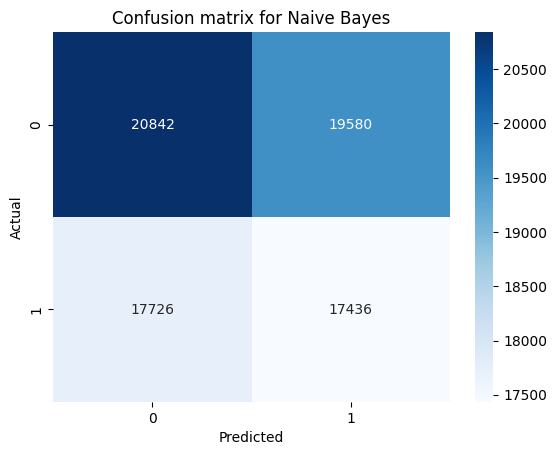

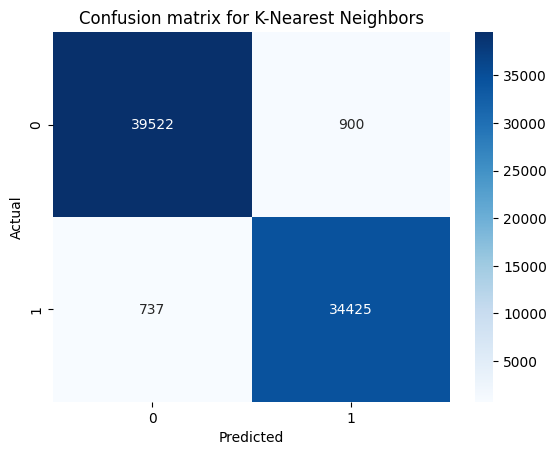

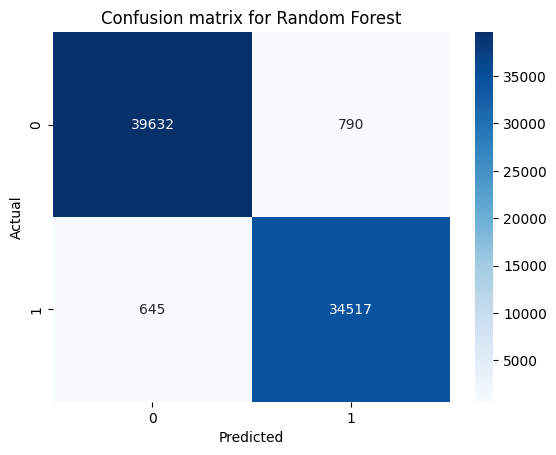

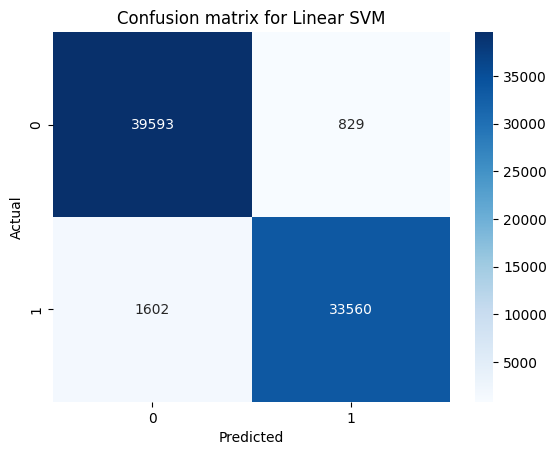

In [ ]:
for model_name, model in zip(model_names, models):
  model_results = ML_results[ML_results['Model'] == model_name]
  model = model_dict[model_name]

  # Make predictions on each of the validation sets
  y_pred = model.predict(binary_val_X)

  # Get the true labels for each the validation sets
  y_true = binary_val_y

# Calculate each of the confusion matrixes
  cm = confusion_matrix(y_true, y_pred)

  # Create heatmaps for the confusion matrixes
  sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title(f'Confusion matrix for {model_name}')
  plt.show()
   